In [115]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
from collections import OrderedDict


class Matching(list):
    def __init__(self, G: nx.Graph, describe: bool = False):
        """Determine a maximam matching from the given bipartite graph `G`.
            G:nx.Graph, the graph from which to determine the matching.
            describe:bool, whetever to explain steps or not.
        """
        self._original_G = G
        self._G, self.describe = G.copy(), describe

        if describe:
            self._setup_describe()
            self._describe_start()
        for node in G.node:
            if self._is_exposed(node):
                if self._search(node):
                    if describe:
                        self._describe_path(node)
                    partial_matchings = [(nx.Graph(self), "Previous Matching")]
                    for i, (j, k) in enumerate(reversed(self._path.items())):
                        if i % 2 == 0:
                            self.append((j, k))
                            partial_matchings.append(
                                (nx.Graph(self),
                                 "Adding edge {k}->{j}.".format(j=j, k=k)))
                        else:
                            for a, e in enumerate(self):
                                if set(e) == set((j, k)):
                                    del self[a]
                                    break
                            partial_matchings.append(
                                (nx.Graph(self),
                                 "Removing edge {k}->{j}.".format(j=j, k=k)))
                    if describe:
                        self._plot_graphs(partial_matchings,
                                          "Updated Matching.")
                else:
                    self._G.remove_node(node)
                    if describe:
                        self._describe_remove_node(node)
        if describe:
            self._describe_result(G)

    def _setup_describe(self):
        self._pos = nx.kamada_kawai_layout(self._G)
        gray, self._dark_gray = '#eeeeee', '#999999'
        self._node_colors = [gray for n in self._G]
        self._edge_colors = [gray for e in self._G.edges]
        positions = np.array(list(self._pos.values()))
        self._min_x, self._min_y = np.min(positions, axis=0) - 0.1
        self._max_x, self._max_y = np.max(positions, axis=0) + 0.1

    def _plot_graphs(self, graphs: list, title: str):
        n, graph_size, graph_per_row = len(graphs), 4, 4
        w, h = min(n, graph_per_row), np.ceil(n / graph_per_row)
        plt.figure(figsize=(graph_size * w, graph_size * h))
        plt.suptitle(title)
        for i, (G, title) in enumerate(graphs):
            colors = [
                "c" if self._original_G.nodes[i]["bipartite"] else "r" for i in G.nodes
            ]
            ax = plt.subplot(h, w, i + 1)
            ax.set_xlim(self._min_x, self._max_x)
            ax.set_ylim(self._min_y, self._max_y)
            ax.set_title(title)
            nx.draw(
                self._original_G,
                pos=self._pos,
                with_labels=True,
                font_color="#999999",
                node_color=self._node_colors,
                edge_color=self._edge_colors)
            nx.draw(
                G,
                pos=self._pos,
                with_labels=True,
                font_color="#222222",
                node_color=colors,
                edge_color=[self._dark_gray for e in G.edges])
        plt.show()

    def _describe_result(self, G: nx.Graph):
        self._plot_graphs([(self._original_G, "Initial Graph"), (self._G, "Final Graph"),
                           (nx.Graph(self), "Final Matching")],
                          "Completed Algorithm.")

    def _describe_start(self):
        self._plot_graphs([(self._G, "Original graph"),
                           (nx.Graph(), "Initial Matching")],
                          "Starting with empty matching.")

    def _describe_remove_node(self, node: int):
        self._plot_graphs(
            [(self._G, "Current Graph"), (nx.Graph(self), "Current Matching")],
            "Removed node {node} from graph.".format(node=node))

    def _describe_path(self, start_node: int):
        self._plot_graphs(
            [(nx.Graph(list(edges.items())), "Step {i} - Path {path}".format(
                i=i, path=list(edges.items())))
             for i, edges in enumerate(self._partial_paths)],
            "Searching for path starting from node {start_node}.".format(
                start_node=start_node))

    def _is_exposed(self, node: int) -> bool:
        """Return a boolean representing if the given `node` is exposed.
            node:int, the node to check for.
        """
        return not self._is_in_matching(node)

    def _is_in_matching(self, node: int) -> bool:
        """Return a boolean representing if the given node is in the matching.
            node:int, the node to check for.
        """
        for a, b in self:
            if node == a or node == b:
                return True
        return False

    def _get_match(self, node: int) -> int:
        """Return the match for a given node.
            node:int, the node to retrieve a matching for.
        """
        for a, b in self:
            if a == node:
                return b
            if b == node:
                return a
        raise ValueError("Given node {node} has no match.".format(node=node))

    def _is_even(self, node: int) -> bool:
        """Return a boolean representing if the given node is labeled as `EVEN`.
            node:int, the node to check parity for.
        """
        return self._labels[node]

    def _is_odd(self, node: int) -> bool:
        """Return a boolean representing if the given node is labeled as `ODD`.
            node:int, the node to check parity for.
        """
        return not self._is_even(node)

    def _is_unlabeled(self, node: int) -> bool:
        """Return a boolean representing if the given node isn't labeled.
            node:int, the node to check labeling for.
        """
        return node not in self._labels

    def _set_node_parity(self, node: int, parity: bool):
        """Set a given node with a given parity label.
            node:int, the node to set to a given parity.
            parity:bool, the value of parity to set it to.
        """
        self._labels[node] = parity

    def _set_even(self, node: int):
        """Set a given node to `EVEN`.
            node:int, the node to set to `EVEN`
        """
        self._set_node_parity(node, True)

    def _set_odd(self, node: int):
        """Set a given node to `ODD`.
            node:int, the node to set to `ODD`
        """
        self._set_node_parity(node, False)

    def _prepend_node(self, node: int):
        """Prepend given `node` to `nodes` list.
            node:int, the node to add to list.
        """
        self._nodes.insert(0, node)
        #self._nodes.append(node)

    def _pop_node(self) -> int:
        """Return first node in nodes list."""
        return self._nodes.pop()

    def _add_step(self, a: int, b: int):
        """Add node to augmenting path."""
        self._path[a] = b
        self._partial_paths.append(OrderedDict(self._path))

    def _reset(self):
        """Reset `labels` dictionary and `nodes` list to a clean state."""
        self._labels, self._nodes, self._path, self._partial_paths = {}, [], OrderedDict(
        ), []

    def _search(self, current: int) -> int:
        """Return, if found, the starting node of an augmenting path ending in given `current` node. Otherwise `-1`.
            current:int, the node from which the search will start.
        """
        self._reset()
        self._set_even(current)
        self._prepend_node(current)
        while self._nodes:
            node = self._pop_node()
            if self._is_even(node):
                if self._search_even(node):
                    return True
            else:
                self._search_odd(node)
        return False

    def _search_even(self, vertex: int):
        """Return, if found, the end of the augmenting path otherwise determines the even odd in the path.
            vertex:int, the even node in the current augmenting path.
        """
        for node in self._G.neighbors(vertex):
            if self._is_exposed(node):
                self._add_step(vertex, node)
                return True
            if self._is_in_matching(node) and self._is_unlabeled(node):
                self._set_odd(node)
                self._add_step(vertex, node)
                self._prepend_node(node)
        return False

    def _search_odd(self, vertex: int):
        """Determine the odd step in the augmenting path.
            vertex:int, the odd node in the current augmenting path.
        """
        node = self._get_match(vertex)
        if self._is_unlabeled(node):
            self._set_even(node)
            self._add_step(vertex, node)
            self._prepend_node(node)

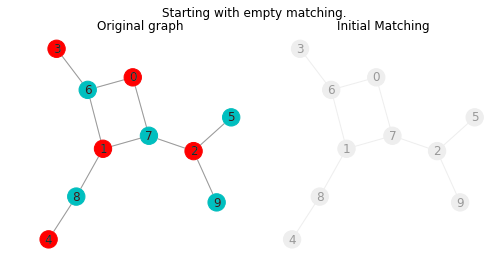

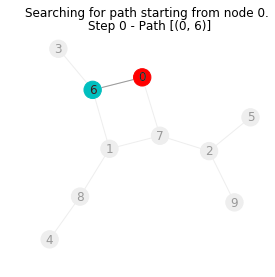

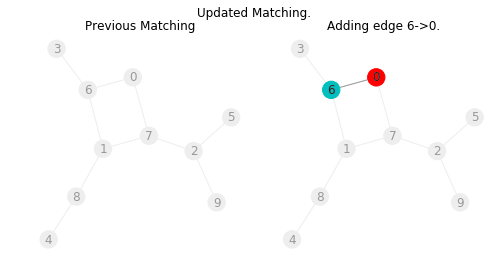

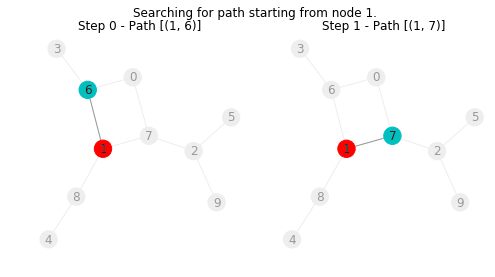

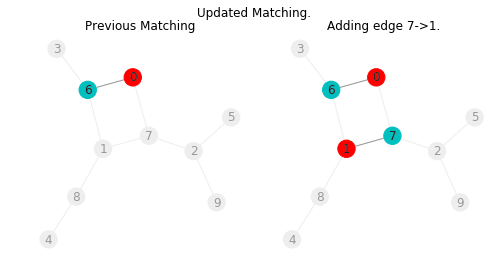

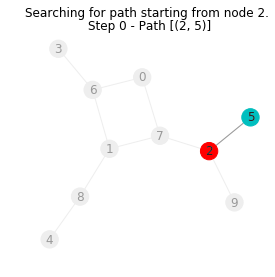

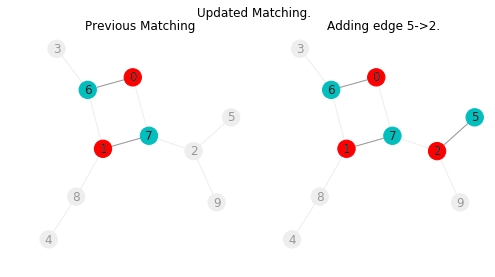

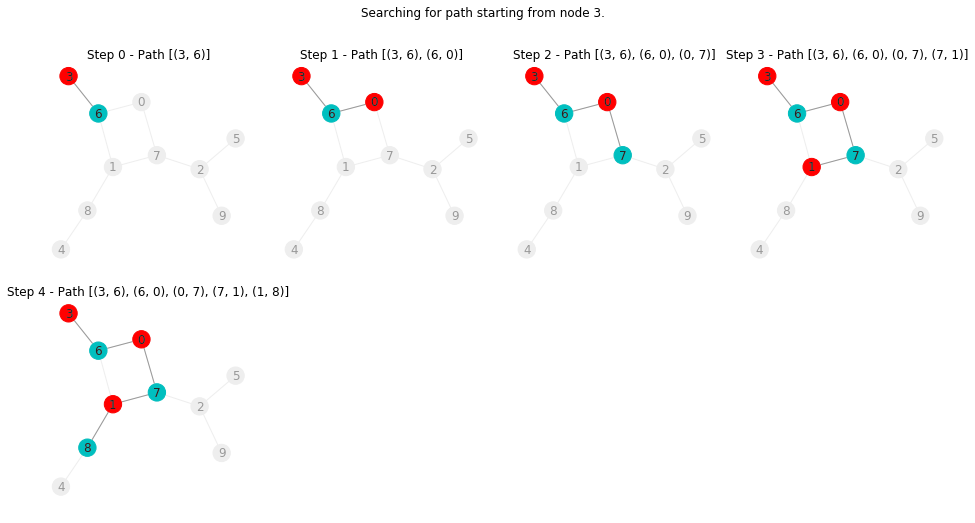

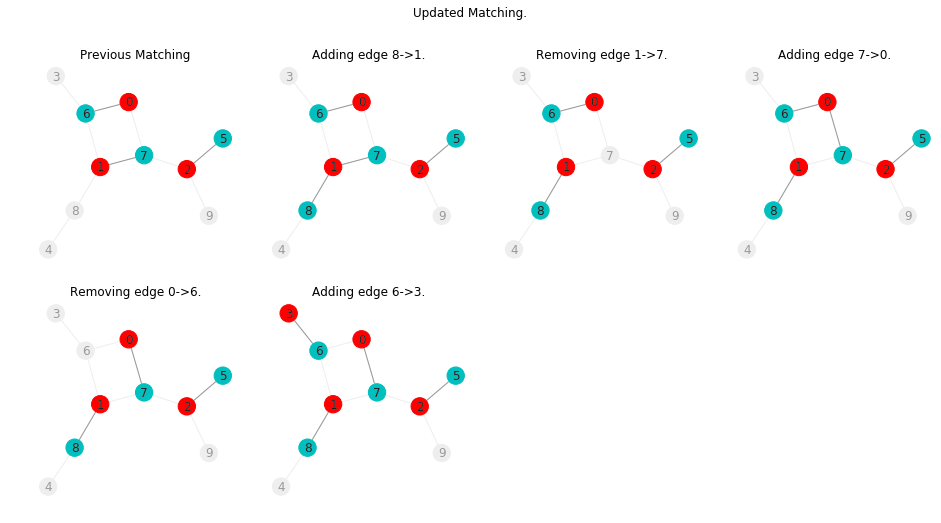

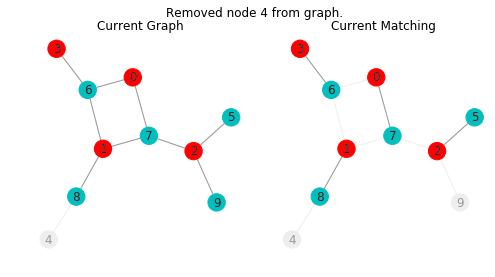

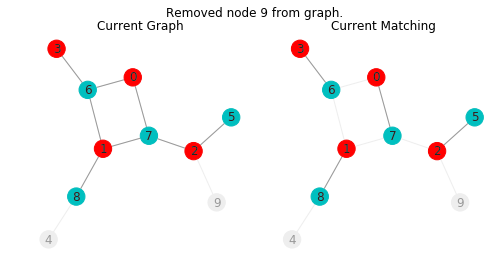

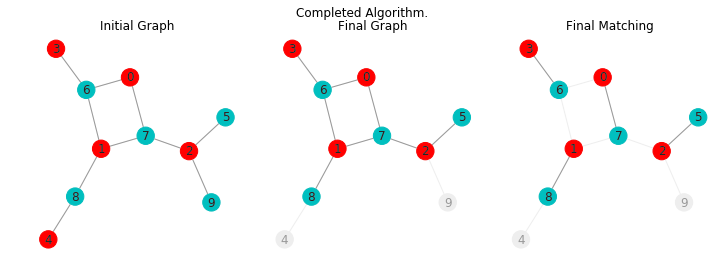

In [116]:
M = Matching(G, describe=True)